    Douglas Kosvoski
    1911100022

# Part 1

## Loading Libraries

In [ ]:
!pip install tomotopy spacy > /dev/null

In [ ]:
import sys
import spacy
import gensim

import pandas as pd
import tomotopy as tp
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from gensim.models.phrases import Phrases, Phraser
from bs4 import BeautifulSoup

spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [ ]:
""" The dataset is avaiable through google sheets api """
# https://docs.google.com/spreadsheets/d/1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA

sheet_id = "1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet="

df = pd.concat([
  pd.read_csv(url + 'train').drop(['Id', 'CreationDate', 'Y'], axis=1),
  pd.read_csv(url + 'valid').drop(['Id', 'CreationDate', 'Y'], axis=1)
])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   60000 non-null  object
 1   Body    60000 non-null  object
 2   Tags    60000 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [ ]:
def get_average_feature_length(docs, feature):
  total_size = 0
  max_size = 0
  min_size = 999

  for i in docs:
    length = len(i)
    total_size += length
  
    if length > max_size:
      max_size = length

    if length < min_size:
      min_size = length
    
  print(f"\n{'-'*10} {feature} {'-'*10}")
  print(f"Average # of {feature}: {int(total_size / len(docs))}")
  print(f"Max # of {feature}: {max_size}")
  print(f"Min # of {feature}: {min_size}")
  return int(total_size / len(docs))

avg_title_size = get_average_feature_length(df['Title'], 'Title')
avg_body_size  = get_average_feature_length(df['Body'], 'Body')
avg_tag_size   = get_average_feature_length(df['Tags'], 'Tags')


---------- Title ----------
Average # of Title: 53
Max # of Title: 150
Min # of Title: 7

---------- Body ----------
Average # of Body: 980
Max # of Body: 35288
Min # of Body: 7

---------- Tags ----------
Average # of Tags: 25
Max # of Tags: 112
Min # of Tags: 3


In [ ]:
number_of_docs = 100
feature = df.Body

docs = list(feature)[:number_of_docs]
print(len(docs))

100


## Remove HTML tags

In [ ]:
def remove_special_characters(character):
  if character.isalnum() or character in [' ', '.', '\n']:
    return True
  return False

def remove_tags(docs):
  cleaned_docs = []
  tags = r"<pre>|</pre>|<a|</a>|<img>|</img>|href|http"

  count = 0
  for doc in docs:
    print(f"{count} out of {len(docs)}", end="\r")
    split_string = re.split(tags, doc.strip().replace('\n', ''))
    clean_doc = ''

    for i in split_string:
      i = i.strip()
      if not (i.startswith('<code>') or i.startswith('=')):
        text = BeautifulSoup(i.strip(), "lxml").text
        asd = "".join(filter(remove_special_characters, text))
        clean_doc += asd

    cleaned_docs.append(clean_doc.strip())
    count += 1
  return cleaned_docs

In [ ]:
docs_without_tags = remove_tags(docs)

In [ ]:
for i, t in enumerate(zip(docs_without_tags)):
  if 'character' in t:
    print(t)
    break
  print(i, t)

0 ('Im already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print Hello World to the console every random seconds from 15. Unfortunately Im in a bit of a rush and dont have any code to show so far. Any help would be apriciated.',)
1 ('Id like to understand why Java 8 Optionals were designed to be immutable.  Is it just for threadsafety',)
2 ('I am attempting to overlay a title over an image  with the image darkened with a lower opacity. However the opacity effect is changing the overlaying text as well  making it dim. Any fix to this Here is what is looks likesi.stack.imgur.com1HzD7.png relnoreferrersi.stack.imgur.com1HzD7.png altenter image description here',)
3 ('The question is very simple but I just could not find the answerWhy doesntcompile butdoesThis is really weird because all the other operators dont need an extra white space. e.g.are the same.I think it has something to do with optionals. But when you u

## Lematization

In [ ]:
def lematize(docs):
  dlemma, total_size = [], len(docs)

  for i, d in enumerate(docs):
    print(f"{i} out of {total_size}", end='')
    lm = " ".join([token.lemma_ for token in nlp(d) if not (token.is_stop == True or token.is_digit == True or token.is_punct == True)])
    dlemma.append(lm.lower())
    print('\r\r\r\r\r\r\r\r', end='')
  return dlemma

In [ ]:
dlemma = lematize(docs)

In [ ]:
for i in dlemma[:10]:
  print(i)

< p > i'm familiar repeat task n second java.util timer java.util timertask lets want print hello world console random second unfortunately bit rush code far help apriciate   < /p > 

< p > i'd like understand java optional design immutable   thread safety?</p > 

< p > attempt overlay title image image darken low opacity opacity effect change overlay text make dim fix look like:</p > 

 < p><a href="https://i.stack.imgur.com/1hzd7.png rel="noreferrer"><img src="https://i.stack.imgur.com/1hzd7.png alt="enter image description here"></a></p > 

 < p > code custom component article preview image row article preview component < /p > 

 < pre><code>//component article preview touchable image 
 require following 
 rss feed api 
 user keyword interest parse home.js 
 parse db need augment include heart 
 parse db need augment include press like google news 
 
 var react = require('react native 
 var 
   view 
   stylesheet 
   text 
   image 
   touchablehighlight 
 = react 

 //dimension 
 

## Tokenization

In [ ]:
min_length = 4
dtoken = [gensim.utils.simple_preprocess(d, deacc=True, min_len=min_length) for d in dlemma]

In [ ]:
for i in dtoken:
  if 'character' in i and 'offset' in i:
    print(i)
    
  # print(i)

## N-grams

In [ ]:
bigram  = Phraser(Phrases(dtoken, min_count=2, threshold=10))
bdocs   = [bigram[d] for d in dtoken]

In [ ]:
def get_bigrams(docs):
  bigrams = []
  for doc in bdocs:
    for j in doc:
      if '_' in j and j not in bigrams:
        bigrams.append(j)

  return bigrams

In [ ]:
print(get_bigrams(bdocs)[:10])

['java_util', 'look_like', 'href_https', 'stack_imgur', 'noreferrer_https', 'enter_image', 'description_here', 'article_preview', 'this_props', 'onpress_this']


## Metrics

In [ ]:
def stats_about_the_docs(docs, feature):
  total_size = 0
  max_size = 0
  min_size = 999

  for i in docs:
    length = len(i)
    total_size += length
  
    if length > max_size:
      max_size = length

    if length < min_size and length != 0:
      min_size = length
    
  print(f"{'-'*10} {feature} {'-'*10}")
  print(f"Average # of {feature}: {int(total_size / len(docs))}")
  print(f"Max # of {feature}: {max_size}")
  print(f"Min # of {feature}: {min_size}")

In [ ]:
stats_about_the_docs(bdocs, 'Words')

---------- Words ----------
Average # of Words: 56
Max # of Words: 489
Min # of Words: 6


## Wordcloud

In [ ]:
def create_single_string(tokens):
  output = ''
  for i in tokens:
    for j in i:
      output += j + " "

  return output

output = create_single_string(bdocs)
output

'familiar repeat task second java_util timer java_util timertask lets want print hello world console random second unfortunately rush code help apriciate like understand java optional design immutable thread safety attempt overlay title image image darken opacity opacity effect change overlay text make look_like href_https stack_imgur noreferrer_https stack_imgur enter_image description_here code custom component article_preview image article_preview component code component article_preview touchable image require following feed user keyword interest parse home parse need augment include heart parse need augment include press like google news react require react native view stylesheet text image react dimension dimensions require dimension window dimensions window imagebutton require common imagebutton keywordbox require authentication onboarding keyword additional library module export react createclass onpress function trigger button press this_props text property dynamically fill bu

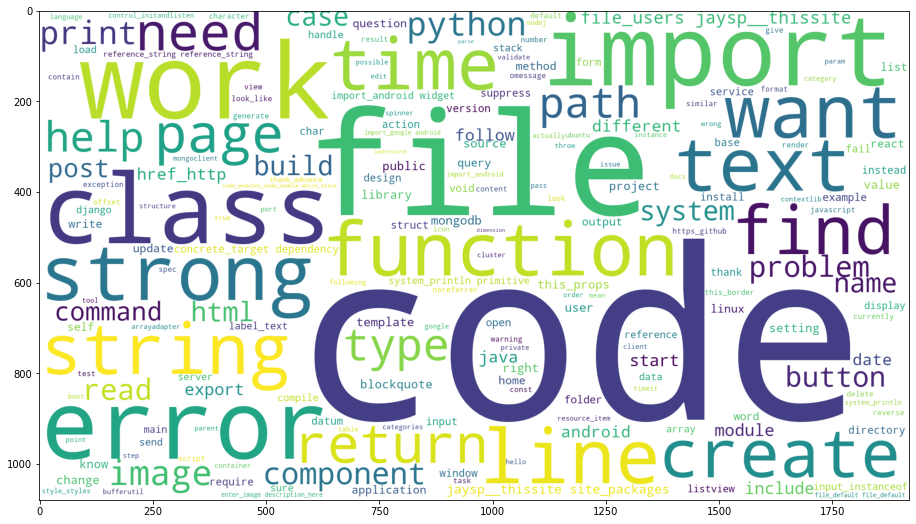

In [ ]:
import wordcloud as wc
import matplotlib.pyplot as plt

mycloud = wc.WordCloud(prefer_horizontal=1, width=1920, height=1080, min_font_size=6, background_color='white').generate(output)
plt.figure(figsize=(16,9))
plt.imshow(mycloud)

# Part 2

## Feature Extraction

In [ ]:
def join_docs(docs):
  docs = []

  for i in bdocs:
    for j in i:
      docs.append(j)

  return docs

joined_docs = join_docs(bdocs)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_docs)

features  = vectorizer.get_feature_names_out()
dense     = X.todense()
denseList = dense.tolist()

In [ ]:
df = pd.DataFrame(denseList, columns=set(features))
for feature in df.columns:
  print(feature, df[feature].unique())

currently [0. 1.]
templateurl_view [0. 1.]
assignment [0. 1.]
backgroundcolor [0. 1.]
func [0. 1.]
import_google [0. 1.]
odometer [0. 1.]
tostre [0. 1.]
newsockfd [0. 1.]
views [0. 1.]
zxingobjc [0. 1.]
initialstate [0. 1.]
display [0. 1.]
here [0. 1.]
this_border [0. 1.]
charset [0. 1.]
heyscriptingguy [0. 1.]
returns [0. 1.]
page [0. 1.]
service_date [0. 1.]
window [0. 1.]
prepend [0. 1.]
credit [0. 1.]
stejskal [0. 1.]
those [0. 1.]
clean [0. 1.]
leave [0. 1.]
recent [0. 1.]
get_response [0. 1.]
shutil [0. 1.]
urlresolver [0. 1.]
deleted [0. 1.]
moment [0. 1.]
node_modules_node_modules [0. 1.]
camera [0. 1.]
props_text [0. 1.]
correct [0. 1.]
continuously [0. 1.]
deintegrate [0. 1.]
approach [0. 1.]
stack [0. 1.]
django_conf [0. 1.]
test [0. 1.]
inspector [0. 1.]
link [0. 1.]
secure [0. 1.]
skip [0. 1.]
endif [0. 1.]
raise [0. 1.]
please_enter [0. 1.]
redux [0. 1.]
spinner [0. 1.]
behavior_ [0. 1.]
work_fine [0. 1.]
personal [0. 1.]
native [0. 1.]
arraylist_string [0. 1.]
city [0. 1

## Model

In [ ]:
def get_coherence(mdl):
	average_coherence = 0
	for preset in ['c_v']:
		coh = tp.coherence.Coherence(mdl, coherence=preset)
		average_coherence = coh.get_score()
	return average_coherence

def runModel(mdl, docs):
	for i, d in enumerate(docs):
		mdl.add_doc(d)
	
	mdl.burn_in = 100
	mdl.train(0)
 
	for i in range(0, 100, 2):
		mdl.train(10)
	# mdl.save('test.lda.bin', True)

def printTopics(mdl, p=False, top_n=10):
	for k in range(mdl.k):
		print(f" -> Topic #{k}")

		for word, prob in mdl.get_topic_words(topic_id=k, top_n=top_n):
			if p:
				print(f"{'%20s' % word} ({'%.2f' % prob})", end=" ")
			else:
	 			print(f"{word.strip()}", end=" ")
		print()

In [ ]:
# tp.LDAModel docs
# bab2min.github.io/tomotopy/v0.4.1/en/#tomotopy.LDAModel

best_alpha, best_beta = None, None
# alpha, beta = [0.1, 0.5, 1, 1.5, 2], alpha.copy()
alpha, beta = 2, 2

mdl, best_model = None, None
cv_scores = []
step = 1

for a in [alpha]:
  for b in [beta]:
    for i in range(1, len(bdocs)+1, step):
      print(f"{i} out of {len(bdocs)}")
      mdl = tp.LDAModel(
        tw      = tp.TermWeight.IDF,
        min_cf  = 3,
        rm_top  = 5,
        k       = i,
        seed    = 777,
        alpha   = a,
        eta     = b
      )

      runModel(mdl, bdocs)
      current_coherence = get_coherence(mdl)

      cv_scores.append(current_coherence)

      if current_coherence >= max(cv_scores):
        print(f"\n{'-'*10} Better params found!!! {'-'*10}")
        print(f"Alpha: {a} \t Beta: {b} \t Score: {'%.4f' % current_coherence}\n")
        best_model = mdl
        best_alpha = a
        best_beta  = b

1 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.4508

2 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.7253

3 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.7553

4 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8192

5 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8618

6 out of 100
7 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8824

8 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8901

9 out of 100
10 out of 100
11 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9043

12 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9167

13 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9171

14 out 

In [ ]:
print(cv_scores)

[0.45075272805988786, 0.725340498238802, 0.7553376495838164, 0.819238831102848, 0.8618328487873079, 0.8473773380120595, 0.8824020189898354, 0.8901240482926369, 0.8873188422785865, 0.8886539983749389, 0.9042549561370503, 0.9166779031356175, 0.9171135356793036, 0.9190685038055693, 0.9194044089317323, 0.9110239461064338, 0.9273302285110249, 0.9200576845142573, 0.931838147891195, 0.9325159102678301, 0.9390846326237634, 0.9317257355559954, 0.9312630977319634, 0.9199436003963153, 0.936832368373871, 0.9263111722010835, 0.9215767054646106, 0.9239150954144343, 0.9254923744448301, 0.9248169044653575, 0.9164003493324404, 0.9103053722530605, 0.9147784171682415, 0.9238978545455374, 0.9136468173776354, 0.91489477670855, 0.9088016482623846, 0.9125585154483192, 0.9067713595353641, 0.9024911513924601, 0.9135327102207553, 0.9020132289046333, 0.9075541304987529, 0.9063226041468706, 0.9064005475574068, 0.8965290621570918, 0.9050340757725086, 0.8988409874339899, 0.8988826071729463, 0.9016809941530225, 0.89

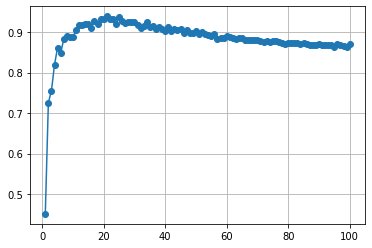

<Figure size 1080x720 with 0 Axes>


Highest coherence is doc #20 with 0.9391


In [ ]:
plt.grid()
x = range(1, len(bdocs)+1, step)
plt.plot(x, cv_scores, marker='o')
plt.figure(figsize=(15, 10))
plt.show()

print(f"\nHighest coherence is doc #{max(zip(cv_scores, x))[1]-1} with {'%.4f' % max(zip(cv_scores, x))[0]}")

# Part 3

In [89]:
try:
  best_model = tp.LDAModel.load('asd.model')
except Exception as e:
  print("Couldn't load the model")

In [90]:
printTopics(best_model, p=True, top_n=10)

 -> Topic #0
            mystring (0.01)         start_thread (0.01)               system (0.01)           convention (0.01)        thread_thread (0.01)         thread_islem (0.01)    console_writeline (0.01)          time_elapse (0.01)            stopwatch (0.01)               mystre (0.01) 
 -> Topic #1
             warning (0.02)              pointer (0.01)                 dark (0.01)                theme (0.01)               struct (0.01)               change (0.01)         printf_value (0.01)               sizeof (0.01)              integer (0.01)             argument (0.01) 
 -> Topic #2
           component (0.02)                 boot (0.02)        resource_item (0.02)             resource (0.01)               folder (0.01)                 crud (0.01)                 task (0.01)            bootstrap (0.01)              angular (0.01)       list_component (0.01) 
 -> Topic #3
    reference_string (0.03)            primitive (0.03)       system_println (0.03)     input_instanceof 

In [394]:
def topics_from_model(mdl, top_n=10):
  list_string = []
  for k in range(10):
    string_doc = '%2d ->' % k

    for word, prob in mdl.get_topic_words(topic_id=k, top_n=top_n):
      string_doc += " " + word
    list_string.append(string_doc.title())
  return list_string

list_string = topics_from_model(best_model, top_n=15)
a = [print(i+'\n') for i in list_string]

 0 -> Mystring Start_Thread System Convention Thread_Thread Thread_Islem Console_Writeline Time_Elapse Stopwatch Mystre Threading Time_Stop System_Console Writeline_Time Elapse_Time

 1 -> Warning Pointer Dark Theme Struct Change Printf_Value Sizeof Integer Argument Structure Message Current Type Blockquote

 2 -> Component Boot Resource_Item Resource Folder Crud Task Bootstrap Angular List_Component Gulp Module Different Structure Javascript

 3 -> Reference_String Primitive System_Println Input_Instanceof Bluebird Input String Output Public Static_Void Byte Short Double Core Long

 4 -> Concrete_Target Dependency Build_Phase Https_Github Spec Project Cjpadcontroller Test_Suite Franklinchen Delete_Copy Pods_Resource Delete_Check Manifest_Lock Pods Libpods_Delete

 5 -> Suppress Timeit Print Innerhtml Contextlib Case Enum Datepicker Valueerror Final Document_Body Input_Field Type Jquery Method

 6 -> Date Saturday Attraction Nooftourist Return Implib Shape Vector Entry Constructor Circ

In [412]:
def find_topics_association_to_docs(model, threshold=0.5):
  """
    Number of times a topic appears
      e.g. topic # X appears Y times in the docs
  """
  appearances = [0 for i in range(model.k)]

  for index, doc in enumerate(model.docs):
    tokens = doc.get_topics()

    for token in tokens:
      token_number, token_score = token[0], token[1]

      if token_score > threshold:
        appearances[token_number] += 1

  return appearances

association = find_topics_association_to_docs(best_model)
association

[4, 3, 6, 3, 4, 4, 5, 4, 3, 9, 1, 10, 8, 3, 1, 5, 7, 6, 3, 6, 5]

In [419]:
def sort_association(assoc):
  import operator

  dic = {}
  for i, j in enumerate(assoc):
    dic[str(i)] = j

  return [int(i[0]) for i in sorted(dic.items(), key=operator.itemgetter(1), reverse=True)]

docs_sorted = sort_association(association)[:10]
docs_sorted

[11, 9, 12, 16, 2, 17, 19, 6, 15, 20]

In [420]:
def print_top_topics(model, docs):
  print(f" {'-'*75} Top 10 topic most associated with docs {'-'*75} \n")
  for i in docs[:10]:
    topic = " ".join([i[0] for i in model.get_topic_words(i)])
    print('%2d ' % i, topic.title())

print_top_topics(best_model, docs_sorted)

# def print_top_topics(model, top_n=10):
#   print(f" {'-'*75} Top 10 topic most associated with docs {'-'*75} \n")
#   for i in range(0, top_n, 1):
#     topic = " ".join(['%18s' % i[0] for i in model.get_topic_words(i)])
#     print(i, topic.title())

# print_top_topics(best_model)

 --------------------------------------------------------------------------- Top 10 topic most associated with docs --------------------------------------------------------------------------- 

11  Text_Nsstring Visualvm Jdkhome Iphone Image Text Load Display Content Unlock
 9  Icon Stack_Imgur Mini Proportion Webpack Dlmwrite Operator Texture Size Hello
12  Export Mongodb Linux Home Control_Initandlisten Android Path Ubuntu Name_Module Android_Home
16  Deploy Odir Test_Test Cflags Evttr Numeric_Evttr Evttr_Freq Deps Idir Powershell
 2  Component Boot Resource_Item Resource Folder Crud Task Bootstrap Angular List_Component
17  Label_Text Reader Odometer Msgbox Textbox_Text Combobox_Text Service Form Port Textbox
19  Offset Word Action News Slider Return_State Oldschool Services_Runescape Time Letter_Word
 6  Date Saturday Attraction Nooftourist Return Implib Shape Vector Entry Constructor
15  Mongoclient Query Array Swift Reverse Changeset Catch_Block People Driver Collectiontype
20  P

In [421]:
labels = [
  "Mobile", #11
  "Image Sprite", #9
  "Linux", #12
  "Windows Server", #16
  "Web Dev", #2
  "HTML", #17
  "Game", #19
  "Vector", #6
  "SGBD Driver", #15
  "Database", #20
]

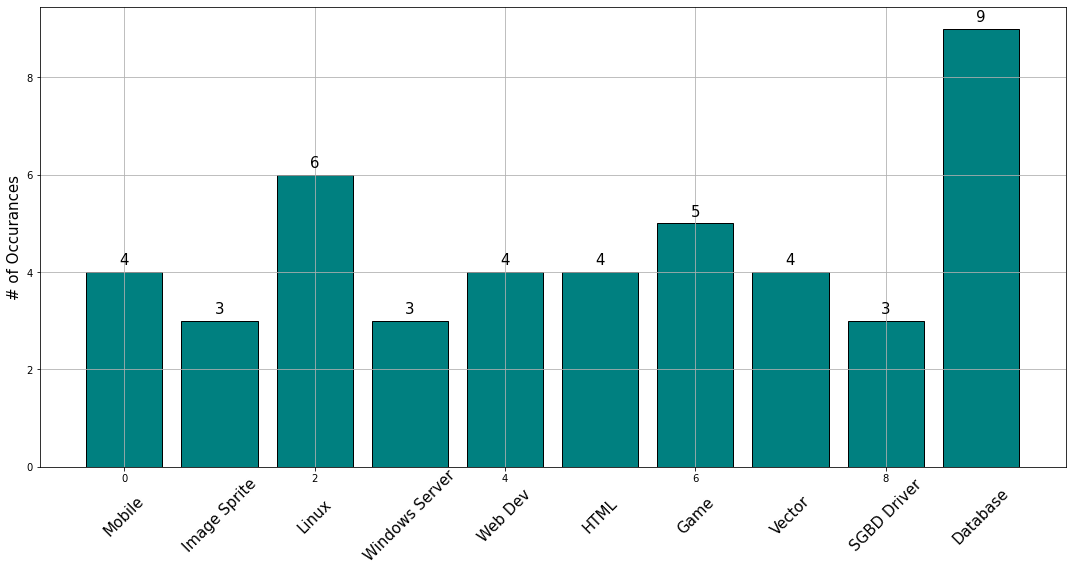

In [422]:
association = association[:10]
plt.figure(figsize=(15, 8))
plt.grid()
plt.bar(range(len(association)), association, color='teal', edgecolor='black')
plt.ylabel('# of Occurances', fontdict=dict(fontsize=15))
plt.rcParams.update({'font.family':'sans-serif'})

for index, data in enumerate(association):
  plt.text(x=index-0.05, y=data+0.15, s=str(data), fontdict=dict(fontsize=15))
  plt.text(
    x        = index,
    y        = -1,
    s        = labels[index],
    rotation = 45,
    fontdict = dict(fontsize=15),
    horizontalalignment = 'center',
    verticalalignment   = 'center'
  )

plt.tight_layout()
plt.show()